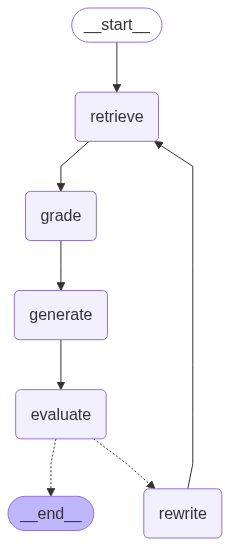

c:\Users\SYED REJAUL KARIM\S2\AI Project\Langgraph_Architecture\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


APIRemovedInV1: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [7]:
import os
from typing import TypedDict
from dotenv import load_dotenv
from modules.retriever import Retriever
from modules.grader import Grader
from modules.generator import Generator
from modules.rewriter import Rewriter
from modules.evaluator import Evaluator
from IPython.display import Image, display
from langgraph.graph import StateGraph, END

load_dotenv()
class PortfolioState(TypedDict):

    query: str

    retrieved: list

    score: float

    answer: str



 
# Load knowledge base
with open("data/knowledge_base.txt") as f:
    docs = f.readlines()

retriever = Retriever(docs)
grader = Grader()
generator = Generator()
rewriter = Rewriter()
evaluator = Evaluator()

def retrieve_node(state):
    query = state["query"]
    retrieved = retriever.retrieve(query)
    return {"query": query, "retrieved": retrieved}

def grade_node(state):
    score = grader.grade(state["retrieved"])
    return {"query": state["query"], "retrieved": state["retrieved"], "score": score}

def generate_node(state):
    answer = generator.generate(state["retrieved"], state["query"])
    return {"query": state["query"], "retrieved": state["retrieved"], "score": state["score"], "answer": answer}

def evaluate_node(state):
    if evaluator.is_answered(state["answer"]):
        return END
    return "rewrite"

def rewrite_node(state):
    new_query = rewriter.rewrite(state["query"])
    return {"query": new_query}

# Build LangGraph
builder = StateGraph(PortfolioState)
builder.add_node("retrieve", retrieve_node)
builder.add_node("grade", grade_node)
builder.add_node("generate", generate_node)
builder.add_node("evaluate", evaluate_node)
builder.add_node("rewrite", rewrite_node)

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "grade")
builder.add_edge("grade", "generate")
builder.add_edge("generate", "evaluate")
builder.add_conditional_edges("evaluate",evaluate_node, {"rewrite": "rewrite", END: END})
builder.add_edge("rewrite", "retrieve")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
# Run the graph
initial_state = {"query": "What are sustainable materials for facades?"}
final_state = graph.invoke(initial_state)
print("\n✅ Final Answer:")
print(final_state["answer"])


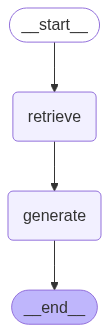

In [10]:
import os
from dotenv import load_dotenv
from modules.retriever import Retriever
from modules.grader import Grader
from modules.generator import Generator
from modules.rewriter import Rewriter
from modules.evaluator import Evaluator

from langgraph.graph import StateGraph, END

load_dotenv()
class PortfolioState(TypedDict):

    query: str

    retrieved: list

    score: float

    answer: str
# Load knowledge base
with open("data/knowledge_base.txt") as f:
    docs = f.readlines()

retriever = Retriever(docs)
grader = Grader()
generator = Generator()
rewriter = Rewriter()
evaluator = Evaluator()

def retrieve_node(state):
    query = state["query"]
    retrieved = retriever.retrieve(query)
    return {"query": query, "retrieved": retrieved}

def grade_node(state):
    score = grader.grade(state["retrieved"])
    return {"query": state["query"], "retrieved": state["retrieved"], "score": score}

def generate_node(state):
    answer = generator.generate(state["retrieved"], state["query"],generator)
    return {"query": state["query"], "retrieved": state["retrieved"], "score": state["score"], "answer": answer}

def evaluate_node(state):
    if evaluator.is_answered(state["answer"]):
        return END
    return "rewrite"

def rewrite_node(state):
    new_query = rewriter.rewrite(state["query"])
    return {"query": new_query}

# Build LangGraph
builder = StateGraph(PortfolioState)
builder.add_node("retrieve", retrieve_node)
#builder.add_node("grade", grade_node)
builder.add_node("generate", generate_node)
#builder.add_node("evaluate", evaluate_node)
#builder.add_node("rewrite", rewrite_node)

# builder.set_entry_point("retrieve")
# builder.add_edge("retrieve", "grade")
# builder.add_edge("grade", "generate")
# builder.add_edge("generate", "evaluate")
# builder.add_conditional_edges("evaluate", {"rewrite": "rewrite", END: END})
# builder.add_edge("rewrite", "retrieve")

builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "generate")
builder.add_edge("generate", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
# Run the graph
# initial_state = {"query": "What are sustainable materials for facades?"}
# final_state = graph.invoke(initial_state)
# print("\n✅ Final Answer:")
# print(final_state["answer"])
